In [1]:
import pandas as pd
from xgboost import XGBClassifier

# Data Preprocessing

In [788]:
vessels = pd.read_csv('./data/vessel_data.csv')
display(vessels.head())

,ship_id,ship_name,latitude,longitude,time,dim_a,dim_b,dim_c,dim_d,length,width,eta_day,eta_hour,eta_minute,eta_month,destination,ship_type,ship_heading,ship_speed
0,304997000,WILSON DIRDAL,60.125667,19.102500,2024-01-04 09:14:59.591590409 +0000 UTC,75.0,13.0,5.0,8.0,88.0,13.0,4.0,11.0,0.0,1.0,FOR ORDER,79.0,138.0,7.2
1,236111925,SOUND SOLUTION,59.354483,17.964942,2024-01-04 09:15:21.493471037 +0000 UTC,12.0,13.0,4.0,6.0,25.0,10.0,28.0,9.0,0.0,12.0,STOCKHOLM,52.0,254.0,0.0
2,265518880,RESCUE BURRE,57.418768,16.677853,2024-01-04 09:15:13.416253033 +0000 UTC,6.0,6.0,2.0,2.0,12.0,4.0,31.0,23.0,59.0,12.0,SWEDISH SAR VESSEL,51.0,87.0,0.0
3,265585310,JUPITER,59.388627,18.327317,2024-01-04 09:15:12.400625784 +0000 UTC,43.0,43.0,9.0,9.0,86.0,18.0,0.0,24.0,60.0,0.0,LJUSTERO<>OSTANA :-),65.0,147.0,0.0
4,265647200,ASKHOLMEN,59.538273,18.750687,2024-01-04 09:15:29.444613983 +0000 UTC,15.0,6.0,3.0,3.0,21.0,6.0,10.0,12.0,0.0,8.0,KLINTSUNDET,99.0,511.0,0.1


In [789]:
vessels_timestamp_fix = vessels.copy()
vessels_timestamp_fix['time'] = pd.to_datetime(vessels['time'].str.replace(" UTC", ""), format='%Y-%m-%d %H:%M:%S.%f %z')
display(vessels_timestamp_fix.head())

,ship_id,ship_name,latitude,longitude,time,dim_a,dim_b,dim_c,dim_d,length,width,eta_day,eta_hour,eta_minute,eta_month,destination,ship_type,ship_heading,ship_speed
0,304997000,WILSON DIRDAL,60.125667,19.102500,2024-01-04 09:14:59.591590409+00:00,75.0,13.0,5.0,8.0,88.0,13.0,4.0,11.0,0.0,1.0,FOR ORDER,79.0,138.0,7.2
1,236111925,SOUND SOLUTION,59.354483,17.964942,2024-01-04 09:15:21.493471037+00:00,12.0,13.0,4.0,6.0,25.0,10.0,28.0,9.0,0.0,12.0,STOCKHOLM,52.0,254.0,0.0
2,265518880,RESCUE BURRE,57.418768,16.677853,2024-01-04 09:15:13.416253033+00:00,6.0,6.0,2.0,2.0,12.0,4.0,31.0,23.0,59.0,12.0,SWEDISH SAR VESSEL,51.0,87.0,0.0
3,265585310,JUPITER,59.388627,18.327317,2024-01-04 09:15:12.400625784+00:00,43.0,43.0,9.0,9.0,86.0,18.0,0.0,24.0,60.0,0.0,LJUSTERO<>OSTANA :-),65.0,147.0,0.0
4,265647200,ASKHOLMEN,59.538273,18.750687,2024-01-04 09:15:29.444613983+00:00,15.0,6.0,3.0,3.0,21.0,6.0,10.0,12.0,0.0,8.0,KLINTSUNDET,99.0,511.0,0.1


In [790]:
# Retreive data from the Mälarbron Bridge API
bridge_df = pd.read_json('https://api.sodertalje.se/getAllBridgestat?start=2024-01-03&end=2025-12-31')
display(bridge_df.head())

,type,state,state_text,formatted_time,alias,ts,latitude,longitude,gmap
0,Bridge,1,Uppfälld bro,2024-01-03 04:01:06,Mälarbron,1704250866722,59.199856,17.628108,https://www.google.com/maps/search/?api=1&quer...
1,Bridge,0,Nedfälld bro,2024-01-03 04:10:45,Mälarbron,1704251445859,59.199856,17.628108,https://www.google.com/maps/search/?api=1&quer...
2,Bridge,1,Uppfälld bro,2024-01-03 04:17:23,Mälarbron,1704251843759,59.199856,17.628108,https://www.google.com/maps/search/?api=1&quer...
3,Bridge,0,Nedfälld bro,2024-01-03 04:26:56,Mälarbron,1704252416749,59.199856,17.628108,https://www.google.com/maps/search/?api=1&quer...
4,Bridge,1,Uppfälld bro,2024-01-03 11:25:25,Mälarbron,1704277525142,59.199856,17.628108,https://www.google.com/maps/search/?api=1&quer...


In [791]:
from datetime import timezone

bridge_df['time'] = pd.to_datetime(bridge_df['formatted_time'])

# Fix the timezone by converting from GMT+1 to GMT
bridge_df['time'] = bridge_df['time'].dt.tz_localize('Etc/GMT+1')
bridge_df['time'] = bridge_df['time'].dt.tz_convert('GMT')

print(bridge_df.head())

     type  state    state_text      formatted_time      alias             ts  \
0  Bridge      1  Uppfälld bro 2024-01-03 04:01:06  Mälarbron  1704250866722   
1  Bridge      0  Nedfälld bro 2024-01-03 04:10:45  Mälarbron  1704251445859   
2  Bridge      1  Uppfälld bro 2024-01-03 04:17:23  Mälarbron  1704251843759   
3  Bridge      0  Nedfälld bro 2024-01-03 04:26:56  Mälarbron  1704252416749   
4  Bridge      1  Uppfälld bro 2024-01-03 11:25:25  Mälarbron  1704277525142   

    latitude  longitude                                               gmap  \
0  59.199856  17.628108  https://www.google.com/maps/search/?api=1&quer...   
1  59.199856  17.628108  https://www.google.com/maps/search/?api=1&quer...   
2  59.199856  17.628108  https://www.google.com/maps/search/?api=1&quer...   
3  59.199856  17.628108  https://www.google.com/maps/search/?api=1&quer...   
4  59.199856  17.628108  https://www.google.com/maps/search/?api=1&quer...   

                       time  
0 2024-01-03 05:01:0

In [792]:
"""
Resamples time series data at given intervals (timestep) for each unique vessel,
filling missing values by backfilling from the previous available data point.
    
:param df: DataFrame containing the timestamped vessel data
:param df: String defining the time step, default '15T' 
:return: DataFrame containing the resampled data.
"""
def resample_and_fill_missing_values(df, time_step='15T'):
    unique_ships = df['ship_id'].unique()
    df = df.set_index('time')
    resampled_data = pd.DataFrame()

    for ship_id in unique_ships:
        ship_data = df[df['ship_id'] == ship_id]
        resampled_ship_data = ship_data.resample(time_step).bfill().reset_index()
        resampled_data = pd.concat([resampled_data, resampled_ship_data], ignore_index=True)

    return resampled_data

In [793]:
vessels_resampled_df = resample_and_fill_missing_values(vessels_timestamp_fix, '15T')
display(vessels_resampled_df.head())

,time,ship_id,ship_name,latitude,longitude,dim_a,dim_b,dim_c,dim_d,length,width,eta_day,eta_hour,eta_minute,eta_month,destination,ship_type,ship_heading,ship_speed
0,2024-01-04 09:00:00+00:00,304997000,WILSON DIRDAL,60.125667,19.102500,75.0,13.0,5.0,8.0,88.0,13.0,4.0,11.0,0.0,1.0,FOR ORDER,79.0,138.0,7.2
1,2024-01-04 09:15:00+00:00,304997000,WILSON DIRDAL,60.108977,19.128717,75.0,13.0,5.0,8.0,88.0,13.0,4.0,11.0,0.0,1.0,FOR ORDER,79.0,138.0,7.5
2,2024-01-04 09:30:00+00:00,304997000,WILSON DIRDAL,60.091500,19.155000,75.0,13.0,5.0,8.0,88.0,13.0,4.0,11.0,0.0,1.0,FOR ORDER,79.0,136.0,7.6
3,2024-01-04 09:45:00+00:00,304997000,WILSON DIRDAL,60.074167,19.182500,75.0,13.0,5.0,8.0,88.0,13.0,4.0,11.0,0.0,1.0,FOR ORDER,79.0,138.0,7.5
4,2024-01-04 10:00:00+00:00,304997000,WILSON DIRDAL,60.042333,19.236833,75.0,13.0,5.0,8.0,88.0,13.0,4.0,11.0,0.0,1.0,FOR ORDER,79.0,134.0,7.6


In [794]:
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

def is_within_area(row, area_polygon):
    boat_location = Point(row['longitude'], row['latitude'])
    return area_polygon.contains(boat_location)

,time,ship_id,ship_name,latitude,longitude,dim_a,dim_b,dim_c,dim_d,length,width,eta_day,eta_hour,eta_minute,eta_month,destination,ship_type,ship_heading,ship_speed
1190,2024-01-04 09:15:00+00:00,244140468,GREENLAND,59.171000,17.664350,94.0,16.0,7.0,7.0,110.0,14.0,4.0,6.0,0.0,1.0,KOPING,70.0,348.0,6.2
1191,2024-01-04 09:30:00+00:00,244140468,GREENLAND,59.187850,17.635300,94.0,16.0,7.0,7.0,110.0,14.0,4.0,6.0,0.0,1.0,KOPING,70.0,325.0,2.4
1192,2024-01-04 09:45:00+00:00,244140468,GREENLAND,59.192150,17.632417,94.0,16.0,7.0,7.0,110.0,14.0,4.0,6.0,0.0,1.0,KOPING,70.0,354.0,0.5
1193,2024-01-04 10:00:00+00:00,244140468,GREENLAND,59.198400,17.629450,94.0,16.0,7.0,7.0,110.0,14.0,4.0,6.0,0.0,1.0,KOPING,70.0,333.0,3.7
1194,2024-01-04 10:15:00+00:00,244140468,GREENLAND,59.209683,17.614933,94.0,16.0,7.0,7.0,110.0,14.0,4.0,6.0,0.0,1.0,KOPING,70.0,318.0,7.0


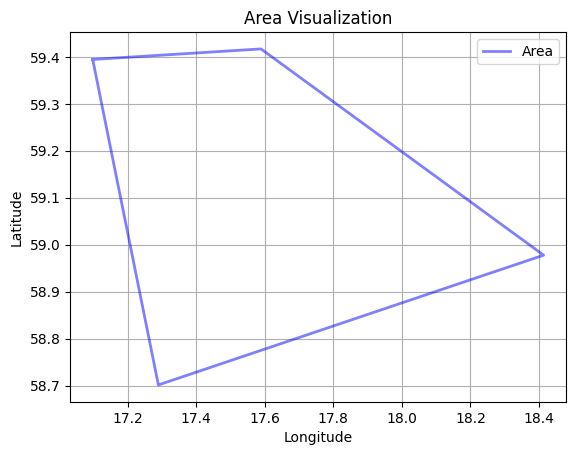

In [795]:
# Define the area
area_coordinates = [(17.09776409369716, 59.39450752033877), (17.58890720737646, 59.4169265974516), 
                    (18.413654438791557, 58.977659362589186), (17.28941977865246, 58.70128810203788)]
area_polygon = Polygon(area_coordinates)

# Filter to keep only boats within the area
vessels_filtered_df = vessels_resampled_df[vessels_resampled_df.apply(is_within_area, axis=1, area_polygon=area_polygon)]

display(vessels_filtered_df.head())

# Plot the area (no map)
x, y = area_polygon.exterior.xy
plt.plot(x, y, color='blue', alpha=0.5, linewidth=2, label='Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Area Visualization')
plt.legend()
plt.grid(True)
plt.show()

In [848]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

def calculate_angle(boat_lat, boat_long, bridge_lat, bridge_long):
    delta_longitude = bridge_long - boat_long
    x = np.cos(np.radians(bridge_lat)) * np.sin(np.radians(delta_longitude))
    y = np.cos(np.radians(boat_lat)) * np.sin(np.radians(bridge_lat)) - np.sin(np.radians(boat_lat)) * np.cos(
        np.radians(bridge_lat)) * np.cos(np.radians(delta_longitude))
    angle = np.degrees(np.arctan2(x, y))

    return angle

def calculate_distance(boat_lat, boat_long, bridge_lat, bridge_long):
    # Calculate the distance using the Haversine formula https://en.wikipedia.org/wiki/Haversine_formula
    phi_1 = radians(boat_lat)
    phi_2 = radians(boat_long)

    delta_phi = radians(bridge_long - boat_long)
    delta_lambda = radians(bridge_lat - boat_lat)

    a = sin(delta_phi / 2) ** 2 + cos(phi_1) * cos(phi_2) * sin(delta_lambda / 2) ** 2
    
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    earth_radius = 6371000 # Earth radius in meters

    distance = earth_radius * c
    
    return distance





In [869]:
import pandas as pd
import numpy as np

def process_vessels_data(df, time_step='15T'):
    df['is_moving'] = df['ship_speed'] > 0
    df['angle_to_bridge'] = calculate_angle(df['latitude'], df['longitude'], 59.19985816310993, 17.628248643747433)
    df['is_moving_towards_bridge'] = np.abs(df['ship_heading'] - df['angle_to_bridge']) <= 10  # within +/- 10 degrees
    df['distance_to_bridge_meters'] = df.apply(lambda row: calculate_distance(row['latitude'], row['longitude'], 59.19985816310993, 17.628248643747433), axis=1)
    df['is_closer_than_1km'] = (df['distance_to_bridge_meters'] < 1000)
    df['larger_ship_type'] = ((df['ship_type'].between(70, 79)) | (df['ship_type'].between(80, 88)) | (df['ship_type'] == 36))

    # Group by given intervals
    grouped = df.groupby(pd.Grouper(key='time', freq=time_step))
    
    # Aggregate necessary data
    aggregated_data = grouped.agg({
        'is_moving': 'sum',
        'ship_id': 'nunique',
        'is_moving_towards_bridge': 'sum',
        'width': 'mean',
        'length': 'mean',
        'is_closer_than_1km': 'sum',
        'larger_ship_type': 'sum'
    }).reset_index()

    # Rename columns
    aggregated_data.rename(columns={
        'ship_id': 'unique_boats_count',
        'width': 'average_width',
        'length': 'average_length',
        'is_moving': 'moving_boats_count',
        'is_moving_towards_bridge': 'boats_moving_towards_bridge_count',
        'is_closer_than_1km': 'boats_closer_than_1km',
        'larger_ship_type': 'larger_ship_count'
    }, inplace=True)
    
    return aggregated_data


In [870]:
vessels_aggregated_df = process_vessels_data(vessels_filtered_df, '15T')
display(vessels_aggregated_df.head())

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,time,moving_boats_count,unique_boats_count,boats_moving_towards_bridge_count,average_width,average_length,boats_closer_than_1km,larger_ship_count
0,2024-01-04 09:00:00+00:00,0,2,0,9.000000,37.000000,1,0
1,2024-01-04 09:15:00+00:00,3,14,0,7.785714,40.357143,1,2
2,2024-01-04 09:30:00+00:00,4,14,0,8.642857,43.928571,1,2
3,2024-01-04 09:45:00+00:00,3,14,0,8.642857,43.928571,2,2
4,2024-01-04 10:00:00+00:00,4,14,0,8.642857,43.928571,2,2


In [871]:
def check_bridge_status(row, df):
    current_time = row['time']

    future_time = current_time + pd.Timedelta(minutes=30)

    open_status = df.loc[
        (df['time'] >= current_time) & (df['time'] <= future_time) & (df['state'] == 1)
    ]

    bridge_was_opened = int(len(open_status) > 0)
    
    return bridge_was_opened
   

In [872]:
vessels_aggregated_df['bridge_status'] = vessels_aggregated_df.apply(check_bridge_status, axis=1)
display(vessels_aggregated_df.head())

,time,moving_boats_count,unique_boats_count,boats_moving_towards_bridge_count,average_width,average_length,boats_closer_than_1km,larger_ship_count,bridge_status
0,2024-01-04 09:00:00+00:00,0,2,0,9.000000,37.000000,1,0,0
1,2024-01-04 09:15:00+00:00,3,14,0,7.785714,40.357143,1,2,0
2,2024-01-04 09:30:00+00:00,4,14,0,8.642857,43.928571,1,2,0
3,2024-01-04 09:45:00+00:00,3,14,0,8.642857,43.928571,2,2,0
4,2024-01-04 10:00:00+00:00,4,14,0,8.642857,43.928571,2,2,0


In [873]:
vessels_aggregated_df.set_index('time', inplace=True)

In [874]:
estimate = vessels_aggregated_df[vessels_aggregated_df['bridge_status'] == 0]['bridge_status'].count() / vessels_aggregated_df[vessels_aggregated_df['bridge_status'] == 1]['bridge_status'].count()
print(estimate)

8.21875


In [927]:
from sklearn.model_selection import train_test_split

data = vessels_aggregated_df.copy()

# Create lag features for selected columns
lag = 5  # Number of lag steps
lag_cols = ['moving_boats_count', 'unique_boats_count', 'boats_moving_towards_bridge_count', 'average_width', 
            'average_length', 'boats_closer_than_1km', 'larger_ship_count']
for col in lag_cols:
    for i in range(1, lag + 1):
        data[f'{col}_lag{i}'] = data[col].shift(i)

# Prepare target variable (shift 'bridge_status' by -2 timesteps (30 min into the future))
data['target'] = data['bridge_status']

# Drop rows with NaN
data.dropna(inplace=True)

# Define features and target
features = [col for col in data.columns if col not in ['bridge_status', 'target']]
target = 'target'

X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2)

# Hyperparameter tuning

In [928]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [1, 3, 5, 7],
    'scale_pos_weight': [8, 9, 10, 15]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=5, scoring='f1')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(best_params)

{'learning_rate': 0.1, 'max_depth': 5, 'scale_pos_weight': 8}


# Training Model With the Best Parameters

In [936]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

model = XGBClassifier(**best_params)

model.fit(X_train, y_train.values.ravel())

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred, zero_division=1))

print(y_train.values.ravel())
print(y_train)

Accuracy: 0.8448275862068966
              precision    recall  f1-score   support

           0       0.96      0.87      0.91        52
           1       0.36      0.67      0.47         6

    accuracy                           0.84        58
   macro avg       0.66      0.77      0.69        58
weighted avg       0.90      0.84      0.86        58

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 1
 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0]
time
2024-01-05 07:15:00+00:00    0
2024-01-05 19:00:00+00:00    0
2024-01-04 13:00:00+00:00    0
2024-01-05 14:45:00+00:00    0
2024-01-05 21:15:00+00:00    0
            

In [939]:
feature_importance = model.feature_importances_
print(feature_importance)

[0.01679577 0.01422555 0.01040799 0.02365043 0.02524994 0.00169974
 0.02709616 0.01146336 0.02922212 0.01788045 0.02760286 0.01164434
 0.09214181 0.00952812 0.03424178 0.02592727 0.00072543 0.00885445
 0.08926611 0.         0.01356396 0.00708232 0.02139245 0.0179861
 0.01439954 0.00694429 0.06137074 0.01417446 0.00940738 0.01105246
 0.01379293 0.0812678  0.00448307 0.04662754 0.00713576 0.01475072
 0.09428534 0.00815    0.05413043 0.00116539 0.00187567 0.01733797]


In [924]:
import pandas as pd
import numpy as np

# Generate fake data for each column
num_rows = 1  # Specify the number of rows you want in the DataFrame

data = {
    'moving_boats_count': np.random.randint(0, 50, num_rows),
    'unique_boats_count': np.random.randint(5, 30, num_rows),
    'boats_moving_towards_bridge_count': np.random.randint(0, 20, num_rows),
    'average_width': np.random.uniform(5.0, 15.0, num_rows),
    'average_length': np.random.uniform(10.0, 25.0, num_rows),
    'boats_closer_than_1km': np.random.randint(0, 10, num_rows),
    'larger_ship_count': np.random.randint(0, 5, num_rows),
    'moving_boats_count_lag1': np.random.randint(0, 50, num_rows),
    'moving_boats_count_lag2': np.random.randint(0, 50, num_rows),
    'moving_boats_count_lag3': np.random.randint(0, 50, num_rows),
    'moving_boats_count_lag4': np.random.randint(0, 50, num_rows),
    'moving_boats_count_lag5': np.random.randint(0, 50, num_rows),
    #'moving_boats_count_lag6': np.random.randint(0, 50, num_rows),
    'unique_boats_count_lag1': np.random.randint(5, 30, num_rows),
    'unique_boats_count_lag2': np.random.randint(5, 30, num_rows),
    'unique_boats_count_lag3': np.random.randint(5, 30, num_rows),
    'unique_boats_count_lag4': np.random.randint(5, 30, num_rows),
    'unique_boats_count_lag5': np.random.randint(5, 30, num_rows),
    #'unique_boats_count_lag6': np.random.randint(5, 30, num_rows),
    'boats_moving_towards_bridge_count_lag1': np.random.randint(0, 20, num_rows),
    'boats_moving_towards_bridge_count_lag2': np.random.randint(0, 20, num_rows),
    'boats_moving_towards_bridge_count_lag3': np.random.randint(0, 20, num_rows),
    'boats_moving_towards_bridge_count_lag4': np.random.randint(0, 20, num_rows),
    'boats_moving_towards_bridge_count_lag5': np.random.randint(0, 20, num_rows),
    #'boats_moving_towards_bridge_count_lag6': np.random.randint(0, 20, num_rows),
    'average_width_lag1': np.random.uniform(5.0, 15.0, num_rows),
    'average_width_lag2': np.random.uniform(5.0, 15.0, num_rows),
    'average_width_lag3': np.random.uniform(5.0, 15.0, num_rows),
    'average_width_lag4': np.random.uniform(5.0, 15.0, num_rows),
    'average_width_lag5': np.random.uniform(5.0, 15.0, num_rows),
    #'average_width_lag6': np.random.uniform(5.0, 15.0, num_rows),
    'average_length_lag1': np.random.uniform(10.0, 25.0, num_rows),
    'average_length_lag2': np.random.uniform(10.0, 25.0, num_rows),
    'average_length_lag3': np.random.uniform(10.0, 25.0, num_rows),
    'average_length_lag4': np.random.uniform(10.0, 25.0, num_rows),
    'average_length_lag5': np.random.uniform(10.0, 25.0, num_rows),
    #'average_length_lag6': np.random.uniform(10.0, 25.0, num_rows),
    'boats_closer_than_1km_lag1': np.random.randint(0, 10, num_rows),
    'boats_closer_than_1km_lag2': np.random.randint(0, 10, num_rows),
    'boats_closer_than_1km_lag3': np.random.randint(0, 10, num_rows),
    'boats_closer_than_1km_lag4': np.random.randint(0, 10, num_rows),
    'boats_closer_than_1km_lag5': np.random.randint(0, 10, num_rows),
    #'boats_closer_than_1km_lag6': np.random.randint(0, 10, num_rows),
    'larger_ship_count_lag1': np.random.randint(0, 5, num_rows),
    'larger_ship_count_lag2': np.random.randint(0, 5, num_rows),
    'larger_ship_count_lag3': np.random.randint(0, 5, num_rows),
    'larger_ship_count_lag4': np.random.randint(0, 5, num_rows),
    'larger_ship_count_lag5': np.random.randint(0, 5, num_rows),
    #'larger_ship_count_lag6': np.random.randint(0, 5, num_rows),
    # ... and so on for other lag columns
}

# Create a DataFrame using the generated data
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


   moving_boats_count  unique_boats_count  boats_moving_towards_bridge_count  \
0                  11                  17                                 12   

   average_width  average_length  boats_closer_than_1km  larger_ship_count  \
0        9.42644        20.13443                      8                  0   

   moving_boats_count_lag1  moving_boats_count_lag2  moving_boats_count_lag3  \
0                       31                       43                       26   

   ...  boats_closer_than_1km_lag1  boats_closer_than_1km_lag2  \
0  ...                           6                           4   

   boats_closer_than_1km_lag3  boats_closer_than_1km_lag4  \
0                           7                           5   

   boats_closer_than_1km_lag5  larger_ship_count_lag1  larger_ship_count_lag2  \
0                           8                       1                       2   

   larger_ship_count_lag3  larger_ship_count_lag4  larger_ship_count_lag5  
0                       0 

In [935]:
pred = model.predict(df)

In [926]:
print(pred)

[0]
